In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [2]:
df = pd.read_pickle('../results/results.pkl')

In [3]:
def get_loss(
    activation = 'linear',
    use_bias = 0,
    target_depth = 1,
    frozen_depth = 2,
    init_mode = 'default',
    width = 16,
    exp = 'fnn',
    pretrained = 0,
):
    test_loss = {}
    if pretrained:
        pretrained_idx = df.pretrained == 1
    else:
        # since there are many results with pretrained = NaN
        # they were run before I implemented the pretrained feature in my code
        pretrained_idx = df.pretrained != 1
        
    if tune_bias == 0:
        tune_bias_idx = df.tune_bias == 0
    else:
        # since there are many results with tune_bias = NaN
        # they were run before I implemented the tune_bies feature in my code
        tune_bias_idx = df.tune_bias != 0
        
        
    for method in ['sgd', 'ours']:
        run_idx = (
            (df.activation == activation) & 
            (df.method == method) & 
            (df.use_bias == use_bias) & 
            (df.target_depth == target_depth) & 
            (df.frozen_depth == frozen_depth) & 
            (df.init_mode == init_mode) & 
            (df.width == width) &
            (df.exp == exp) &
            pretrained_idx &
            tune_bias_idx
        )

        group_df = df[run_idx].reset_index(drop = True)
        rank_set = np.unique(group_df['rank'])
        group_df_rank = {}
        test_loss[method] = {}
        for rank in rank_set:
            group_df_rank[rank] = group_df[group_df['rank'] == rank]
            if method == 'sgd':
                min_loss_index = group_df_rank[rank]['val_loss'].idxmin()
                row_with_min_loss = group_df_rank[rank].loc[min_loss_index]
                test_loss[method][rank] = row_with_min_loss['test_loss']
            elif method == 'ours':
                test_loss[method][rank] = group_df_rank[rank]['test_loss'].iloc[0]
            else:
                raise notImplementError(f"We only support sgd and ours, not {method}!")
                
    return {
        'test_loss': pd.DataFrame(test_loss), 
        'sv': group_df['singular_values'],
    }

In [136]:
# loading the data

random_linear = get_loss(
    activation = 'linear',
    use_bias = 0,
    target_depth = 1,
    frozen_depth = 2,
    init_mode = 'default',
    width = 16,
    exp = 'fnn',
    pretrained = 0,
)['test_loss']

random_fnn = get_loss(
    activation = 'relu',
    use_bias = 1,
    target_depth = 1,
    frozen_depth = 2,
    init_mode = 'default',
    width = 16,
    exp = 'fnn',
    pretrained = 0,
)['test_loss']

pretrained_linear = get_loss(
    activation = 'linear',
    use_bias = 0,
    target_depth = 1,
    frozen_depth = 2,
    init_mode = 'default',
    width = 16,
    exp = 'fnn',
    pretrained = 1,
)['test_loss']

pretrained_fnn = get_loss(
    activation = 'relu',
    use_bias = 1,
    target_depth = 1,
    frozen_depth = 2,
    init_mode = 'default',
    width = 16,
    exp = 'fnn',
    pretrained = 1,
)['test_loss']

/tmp/ipykernel_1893539/3585106605.py:16: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
/tmp/ipykernel_1893539/3585106605.py:18: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])


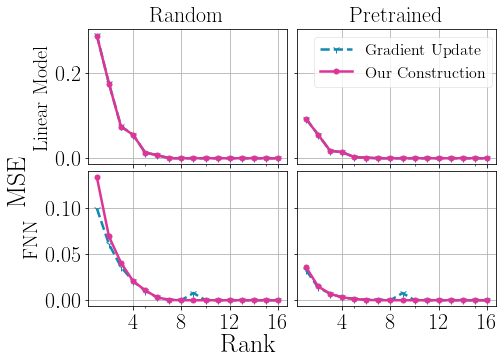

In [137]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = np.arange(16)+1
sgd_marker, sgd_color, sgd_lt, sgd_ms = '1', '#118AB2', '--', 8
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=2, ncols=2, sharex = True)
fig.subplots_adjust(left=0.18, bottom=.15, right=0.99, top=0.92, wspace=0.05, hspace = 0.05) #margin of the figure
fig.set_size_inches(7, 5) #exact size of the figure
# First row share the same y-axis
ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
# Second row share the same y-axis
ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])

random_linear['sgd'].plot(ax = ax[0][0], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
random_linear['ours'].plot(ax = ax[0][0], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)

pretrained_linear['sgd'].plot(ax = ax[0][1], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
pretrained_linear['ours'].plot(ax = ax[0][1], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)

random_fnn['sgd'].plot(ax = ax[1][0], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
random_fnn['ours'].plot(ax = ax[1][0], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)

pretrained_fnn['sgd'].plot(ax = ax[1][1], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
pretrained_fnn['ours'].plot(ax = ax[1][1], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)

# set the x-ticks

for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([4, 8, 12, 16])
        ax[i][j].grid(True)
        
ax[0][1].legend(fontsize=16, bbox_to_anchor=(1.02,1))
ax[0][0].set_title('Random', size = 22, y = 1.01)
ax[0][1].set_title('Pretrained', size = 22, y = 1.01)

fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)

# Set y-labels for each row
ax[0, 0].set_ylabel('Linear Model', fontsize = 20)
ax[1, 0].set_ylabel('FNN', fontsize = 20)

plt.savefig('../figures/main_body.pdf')
# Show the plot
plt.show()


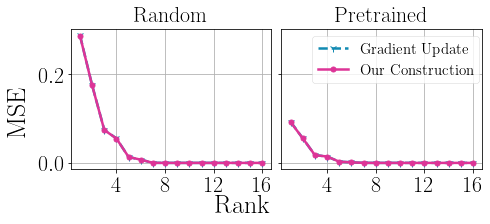

In [138]:
# Figure 1 setup
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
fig.subplots_adjust(left=0.15, bottom=.23, right=0.99, top=0.88, wspace=0.05, hspace=0.05)
fig.set_size_inches(6.8, 3)

random_linear['sgd'].plot(ax=ax[0], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
random_linear['ours'].plot(ax=ax[0], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

pretrained_linear['sgd'].plot(ax=ax[1], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
pretrained_linear['ours'].plot(ax=ax[1], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

# set the x-ticks

for i in range(2):
    ax[i].set_xticks([4, 8, 12, 16])
    ax[i].grid(True)

ax[1].legend(fontsize=15, bbox_to_anchor=(1.02,1))
ax[0].set_title('Random', size = 22, y = 1.01)
ax[1].set_title('Pretrained', size = 22, y = 1.01)

fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)


plt.savefig('../figures/figure1.pdf')
plt.show()

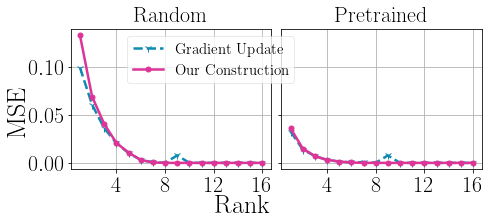

In [139]:
# Figure 2 setup
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
fig.subplots_adjust(left=0.15, bottom=.23, right=0.99, top=0.88, wspace=0.05, hspace=0.05)
fig.set_size_inches(6.8, 3)

random_fnn['sgd'].plot(ax=ax[0], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
random_fnn['ours'].plot(ax=ax[0], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

pretrained_fnn['sgd'].plot(ax=ax[1], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
pretrained_fnn['ours'].plot(ax=ax[1], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

# set the x-ticks

for i in range(2):
    ax[i].set_xticks([4, 8, 12, 16])
    ax[i].grid(True)

ax[1].legend(fontsize=15, bbox_to_anchor=(0.1,1))
ax[0].set_title('Random', size = 22, y = 1.01)
ax[1].set_title('Pretrained', size = 22, y = 1.01)

fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)


plt.savefig('../figures/figure2.pdf')
plt.show()

In [135]:
df[
    (df.pretrained==1) & 
    (df.width == 16) & 
    (df.target_depth == 2) & 
    (df.frozen_depth == 4) & 
    (df.method == 'ours') &
    (df['rank'] == 1)
].iloc[1]['Singular values']

[1.5447925329208374,
 1.2719866037368774,
 1.0974185466766355,
 1.0486873388290403,
 0.9562986493110656,
 0.8814974427223206,
 0.6019706130027771,
 0.577191948890686,
 0.47184088826179504,
 0.41124457120895386,
 0.3715863525867462,
 0.2937816381454468,
 0.19447194039821625,
 0.13346722722053528,
 0.09375804662704468,
 0.019581491127610207]

Index(['_step', 'val_loss', 'pretrain_train_loss', '_wandb', '_runtime',
       'test_loss', '_timestamp', 'train_loss', 'pretrain_val_loss',
       'Singular values', 'singular_values', 'lr', 'exp', 'std', 'rank',
       'wandb', 'width', 'method', 'n_head', 'n_test', 'n_epochs', 'use_bias',
       'init_mode', 'activation', 'batch_size', 'pretrained', 'seq_length',
       'frozen_depth', 'target_depth', 'weight_decay', 'pretrained_lr',
       'pretrained_level', 'pretrained_epochs', 'run_name'],
      dtype='object')